In [12]:
import sys
sys.path.append('../')
from datamodules.mnist import MnistDataset
from core.trainer import Trainer
from models import CNN
from models import MNIST_CONFIG as config
import torch
import numpy as np
from matplotlib import pyplot as plt
from core import project_root
projroot = project_root()

DATA SAVED!
N Examples: 54000
N Classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]
 - Class 0: 5343 (9.894444444444444)
 - Class 1: 6036 (11.177777777777779)
 - Class 2: 5348 (9.903703703703703)
 - Class 3: 5583 (10.338888888888889)
 - Class 4: 5249 (9.720370370370372)
 - Class 5: 4859 (8.998148148148148)
 - Class 6: 5335 (9.87962962962963)
 - Class 7: 5664 (10.488888888888889)
 - Class 8: 5234 (9.692592592592593)
 - Class 9: 5349 (9.905555555555555)
MODEL LOADED!


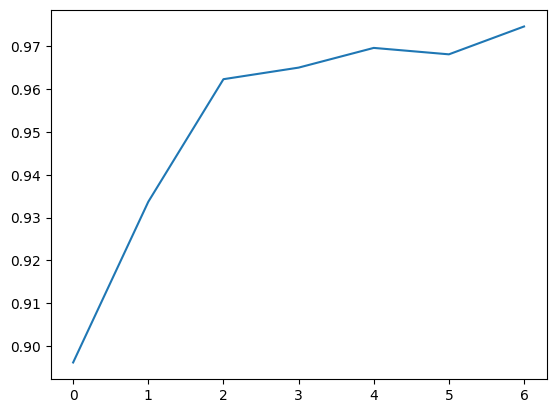

In [13]:
dataset = MnistDataset(tobeloaded=False, params=config.DATA_PARAMS)
dataset.summarize()
model = CNN("mnist", num_classes=10)
trainer = Trainer(params=config.TRAIN_PARAMS)
model.load("mnist")
# trainer.fit(model,dataset)
plt.plot(model.test_scores, label=f'mnist - test scores')

# Install

### [Getting Started](https://pytorch.org/executorch/stable/getting-started-setup.html)
### [Building with CMake](https://pytorch.org/executorch/stable/runtime-build-and-cross-compilation.html)

# Toy Example 
### [PyTorch Source](https://pytorch.org/executorch/stable/tutorials/export-to-executorch-tutorial.html)

![picture 1](images/workflow.png)

In [14]:
import torch.nn as nn

class FullyConnected(torch.nn.Module):
    #Fully Connected layers    
    def __init__(self):
        super().__init__()
        fc_dims = [4,1]
        self.activation = nn.ReLU()
        self.example_args = (torch.randn(1, 4),)
        fc_layers = []
        for i in range(len(fc_dims)-1):
            fc_layers.append(nn.Linear(fc_dims[i],fc_dims[i+1],bias=True))
            fc_layers.append(self.activation)
        self.fc = nn.Sequential(*fc_layers)

    def forward(self, x):
        return self.fc(x)
    
class Add(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.example_args = (torch.randn(1, 4), torch.randn(1, 4))
        
    def forward(self,x,y):
        return x + y
    
# m = FullyConnected()
m = CNN("mnist",num_classes=10)
m(*m.example_args)
# m.load("mnist")

tensor([[-1.2054e-03,  7.8042e-03,  1.5622e+00,  2.0319e-01, -2.5658e-03,
         -8.9394e-05,  9.3103e-01, -5.0285e-03, -1.3109e-02,  4.1132e-01]],
       grad_fn=<MulBackward0>)

1) Pre-Autograd ATen Dialect
    - Trace a module before any pre-autograd decomposition is run. Later this API will be changed like stated [here](https://github.com/pytorch/executorch/issues/290)
        - Tracing means converting a PyTorch model into a more efficient, serialized format suitable for deployment in production or environments where Python might not be available.
    - The result is still nn.Module but only with ATen operations, which are safe for eager mode training
        - Eager mode training means we are still in an imperative fashion
    - We will print the graph, represented through [Torch Fx](https://pytorch.org/docs/stable/fx.html#module-torch.fx), in a table to explicitly represent inputs, operations and outputs (more info [here](https://pytorch.org/docs/stable/fx.html#torch.fx.Node))

In [15]:
from torch._export import capture_pre_autograd_graph
pre_autograd_aten_dialect = capture_pre_autograd_graph(m, m.example_args)
print("Pre-Autograd ATen Dialect Graph")
pre_autograd_aten_dialect.graph.print_tabular()

Pre-Autograd ATen Dialect Graph
opcode         name              target                   args                                              kwargs
-------------  ----------------  -----------------------  ------------------------------------------------  -------------------------------------------------------------------------------
placeholder    arg0_1            arg0                     ()                                                {}
call_function  to                aten.to.dtype            (arg0_1, torch.float32)                           {}
call_function  to_1              aten.to.dtype_layout     (to,)                                             {'dtype': torch.float32, 'layout': torch.strided, 'device': device(type='cpu')}
get_attr       _param_constant0  conv_0_weight            ()                                                {}
get_attr       _param_constant1  conv_0_bias              ()                                                {}
call_function  conv2d            

2) Quantization (optional)
    - Lower the precision, maintaining the accuracy high enough
    - Goal is to enhance memory and computational efficiency

In [16]:
from torch.ao.quantization.quantize_pt2e import convert_pt2e, prepare_pt2e
from torch.ao.quantization.quantizer.xnnpack_quantizer import (
    get_symmetric_quantization_config,
    XNNPACKQuantizer,
)

quantizer = XNNPACKQuantizer().set_global(get_symmetric_quantization_config())
prepared_graph = prepare_pt2e(pre_autograd_aten_dialect, quantizer)
converted_graph = convert_pt2e(prepared_graph)
print("Quantized Graph")
converted_graph.graph.print_tabular()

Quantized Graph
opcode         name                             target                                              args                                                                                  kwargs
-------------  -------------------------------  --------------------------------------------------  ------------------------------------------------------------------------------------  -------------------------------------------------------------------------------
placeholder    arg0_1                           arg0                                                ()                                                                                    {}
call_function  to                               aten.to.dtype                                       (arg0_1, torch.float32)                                                               {}
call_function  to_1                             aten.to.dtype_layout                                (to,)                                          

/home/neverorfrog/.miniconda3/envs/executorch/lib/python3.10/site-packages/torch/ao/quantization/observer.py:1272: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(
/home/neverorfrog/.miniconda3/envs/executorch/lib/python3.10/site-packages/torch/ao/quantization/utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


3) Core ATen Dialect
- [export()](https://pytorch.org/docs/2.1/export.html#torch.export.export) takes an arbitrary Python callable (an nn.Module, a function or a method) and produces a traced graph representing only the Tensor computation of the function in an Ahead-of-Time (AOT) fashion, which can subsequently be executed with different outputs or serialized. 
- The traced graph does three things 
    1) produces a normalized operator set consisting only of functional Core ATen Operator Set and user specified custom operators
    2) has eliminated all Python control flow and data structures (except for certain conditions)
    3) has the set of shape constraints needed to show that this normalization and control flow elimination is sound for a future input.

In [17]:
from torch.export import export, ExportedProgram
aten_dialect: ExportedProgram = export(pre_autograd_aten_dialect, m.example_args)
print("ATen Dialect Graph")
aten_dialect.graph.print_tabular()

ATen Dialect Graph
opcode         name                       target                                args                                                                 kwargs
-------------  -------------------------  ------------------------------------  -------------------------------------------------------------------  --------
placeholder    arg0_1                     arg0_1                                ()                                                                   {}
placeholder    arg1_1                     arg1_1                                ()                                                                   {}
placeholder    arg2_1                     arg2_1                                ()                                                                   {}
placeholder    arg3_1                     arg3_1                                ()                                                                   {}
placeholder    arg4_1                     arg4_1           

4) Edge Dialect
- to_edge() returns an EdgeProgramManager object, which contains the exported programs which will be placed on this device
    - DType specialization
    - Scalar to tensor conversion
    - Converting all ops to the executorch.exir.dialects.edge namespace

In [18]:
from executorch.exir import EdgeProgramManager, to_edge
edge_program: EdgeProgramManager = to_edge(aten_dialect)
print("Edge Dialect Graph")
to_be_lowered_module = edge_program.exported_program()
to_be_lowered_module.graph.print_tabular()

Edge Dialect Graph
opcode         name                                    target                                                                                                                                                                                                                                      args                                                                 kwargs
-------------  --------------------------------------  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  -------------------------------------------------------------------  --------
placeholder    arg0_1                                  arg0_1                                                                                                                                                                                        

5. Delegate to a Backend (optional)

In [19]:
from executorch.exir.backend.backend_api import LoweredBackendModule, to_backend
from executorch.exir.backend.test.backend_with_compiler_demo import (  # noqa
    BackendWithCompilerDemo,
)

6. Executorch Programs

In [20]:
from executorch.exir import ExecutorchBackendConfig, ExecutorchProgramManager
from executorch.exir.passes import MemoryPlanningPass

executorch_program: ExecutorchProgramManager = edge_program.to_executorch(
    ExecutorchBackendConfig(
        passes=[],  # User-defined passes
        memory_planning_pass=MemoryPlanningPass(
            "greedy"
        ),  # Default memory planning pass
    )
)

print("ExecuTorch Dialect")
print(executorch_program.exported_program().graph.print_tabular())


with open(f"{projroot}/model-weights/executorch/cnn/model.pte", "wb") as file:
    file.write(executorch_program.buffer)

ExecuTorch Dialect
opcode         name                                    target                              args                                                                 kwargs
-------------  --------------------------------------  ----------------------------------  -------------------------------------------------------------------  ------------------------------------
placeholder    arg0_1                                  arg0_1                              ()                                                                   {}
placeholder    arg1_1                                  arg1_1                              ()                                                                   {}
placeholder    arg2_1                                  arg2_1                              ()                                                                   {}
placeholder    arg3_1                                  arg3_1                              ()                                   